# Lab 8: Linear Classifiers

In [5]:
import pandas as pd
import numpy as np
from plotnine import *

from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix,\
                            classification_report, precision_score, recall_score, f1_score, roc_auc_score, auc, roc_curve, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [6]:
high = pd.read_csv("cannabis.csv")
high.head()

,Strain,Type,Rating,Effects,Flavor,Description
0,100-Og,hybrid,4.0,"Creative,Energetic,Tingly,Euphoric,Relaxed","Earthy,Sweet,Citrus",$100 OG is a 50/50 hybrid strain that packs a ...
1,98-White-Widow,hybrid,4.7,"Relaxed,Aroused,Creative,Happy,Energetic","Flowery,Violet,Diesel",The ‘98 Aloha White Widow is an especially pot...
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1024 is a sativa-dominant hybrid bred in Spain...
3,13-Dawgs,hybrid,4.2,"Tingly,Creative,Hungry,Relaxed,Uplifted","Apricot,Citrus,Grapefruit",13 Dawgs is a hybrid of G13 and Chemdawg genet...
4,24K-Gold,hybrid,4.6,"Happy,Relaxed,Euphoric,Uplifted,Talkative","Citrus,Earthy,Orange","Also known as Kosher Tangie, 24k Gold is a 60%..."


# Data Cleaning

In [7]:
high.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2351 entries, 0 to 2350
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Strain       2351 non-null   object 
 1   Type         2351 non-null   object 
 2   Rating       2351 non-null   float64
 3   Effects      2351 non-null   object 
 4   Flavor       2305 non-null   object 
 5   Description  2318 non-null   object 
dtypes: float64(1), object(5)
memory usage: 110.3+ KB


In [8]:
# Split the 'Effects' column and create dummy variables
effects_dummies = high['Effects'].str.get_dummies(',')

# Add a prefix to the dummy variable columns
effects_dummies = effects_dummies.add_prefix('E_')

# Convert dummy variable columns to Object type
effects_dummies = effects_dummies.astype('object')

# Concatenate the dummy variables with the original DataFrame
high = pd.concat([high, effects_dummies], axis=1)

In [9]:
# Split the 'Flavor' column and create dummy variables
flavor_dummies = high['Flavor'].str.get_dummies(',')

# Add a prefix to the dummy variable columns
flavor_dummies = flavor_dummies.add_prefix('F_')

# Convert dummy variable columns to Object type
flavor_dummies = flavor_dummies.astype('object')

# Concatenate the dummy variables with the original DataFrame
high = pd.concat([high, flavor_dummies], axis=1)

# Display the updated DataFrame
pd.set_option('display.max_columns', None)
high.head()

,Strain,Type,Rating,Effects,Flavor,Description,E_Aroused,E_Creative,E_Dry,E_Energetic,E_Euphoric,E_Focused,E_Giggly,E_Happy,E_Hungry,E_Mouth,E_None,E_Relaxed,E_Sleepy,E_Talkative,E_Tingly,E_Uplifted,F_Ammonia,F_Apple,F_Apricot,F_Berry,F_Blue,F_Blueberry,F_Butter,F_Cheese,F_Chemical,F_Chestnut,F_Citrus,F_Coffee,F_Diesel,F_Earthy,F_Flowery,F_Fruit,F_Grape,F_Grapefruit,F_Honey,F_Lavender,F_Lemon,F_Lime,F_Mango,F_Menthol,F_Mint,F_Minty,F_None,F_Nutty,F_Orange,F_Peach,F_Pear,F_Pepper,F_Pine,F_Pineapple,F_Plum,F_Pungent,F_Rose,F_Sage,F_Skunk,F_Spicy/Herbal,F_Strawberry,F_Sweet,F_Tar,F_Tea,F_Tobacco,F_Tree,F_Tropical,F_Vanilla,F_Violet,F_Woody
0,100-Og,hybrid,4.0,"Creative,Energetic,Tingly,Euphoric,Relaxed","Earthy,Sweet,Citrus",$100 OG is a 50/50 hybrid strain that packs a ...,0,1,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,98-White-Widow,hybrid,4.7,"Relaxed,Aroused,Creative,Happy,Energetic","Flowery,Violet,Diesel",The ‘98 Aloha White Widow is an especially pot...,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1024 is a sativa-dominant hybrid bred in Spain...,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1
3,13-Dawgs,hybrid,4.2,"Tingly,Creative,Hungry,Relaxed,Uplifted","Apricot,Citrus,Grapefruit",13 Dawgs is a hybrid of G13 and Chemdawg genet...,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,24K-Gold,hybrid,4.6,"Happy,Relaxed,Euphoric,Uplifted,Talkative","Citrus,Earthy,Orange","Also known as Kosher Tangie, 24k Gold is a 60%...",0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
#high.info()

In [11]:
# drop nan values
high = high.dropna()

- Our goal will be to fit models that identify the Sativa types from the Indica types, and then to fit models that also distinguish the Hybrid types.

# Part One: Binary Classification
- Create a dataset that is limited only to the Sativa and Indica type cannabis strains.
- This section asks you to create a final best model for each of the four new model types studied this week: LDA, QDA, SVC, and SVM. For SVM, you may limit yourself to only the polynomial kernel.

For each, you should:

1. Choose a metric you will use to select your model, and briefly justify your choice. (Hint: There is no specific target category here, so this should not be a metric that only prioritizes one category.)

2. Find the best model for predicting the Type variable. Don’t forget to tune any hyperparameters.

3. Report the (cross-validated!) metric.

4. Fit the final model.

5. Output a confusion matrix.




In [12]:
high_binary = high[(high['Type'] == "sativa") | (high['Type'] == "indica")]

X = high_binary.drop(['Type', 'Flavor', 'Effects', 'Strain', 'Description'], axis = 1)
y = high_binary["Type"]

In [13]:
#Preprocessor as a column transformer that dumifies, standardizes.
ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

In [14]:
# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

## Q1: LDA

In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# Model Specification
lda = LinearDiscriminantAnalysis()

#pipeline Creation
model_1_pipeline = Pipeline(
    [("preprocessing", ct),
    ("lda_classification", lda)]
  )

model_1 = model_1_pipeline.fit(X,y)

model_1_pred = model_1.predict(X)

# Metrics for Model 3
print("Metrics for Model_1 :\n")

# Accuracy calculation
cv_scores = cross_val_score(model_1_pipeline, X, y, cv=cv, scoring='accuracy') # Perform cross-validation
roc_auc_model_1 = np.mean(cv_scores)
print("Mean Accuracy Score:", roc_auc_model_1, "\n")

# Confusion matrix
uni_classes = y.unique() #getting the unique classes in the Y variale
conf_matrix_test = confusion_matrix(y, model_1_pred) # making the matrix
class_names = uni_classes.tolist() # Putting the classes to a list
conf_matrix_df = pd.DataFrame(conf_matrix_test, index=class_names, columns=class_names) # Display the confusion matrix with class labels
print("Confusion Matrix for Model_3 : \n")
conf_matrix_df

Metrics for Model_1 :

Mean Accuracy Score: 0.8357985257985259 

Confusion Matrix for Model_3 : 



,sativa,indica
sativa,618,62
indica,82,346


- For LDA I chose accuracy as the score, since this is still technically a multiclass problem. The Score for this model was 84%.

## Q2: QDA


In [16]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# Model Specification
qda = QuadraticDiscriminantAnalysis()

#pipeline Creation
model_2_pipeline = Pipeline(
    [("preprocessing", ct),
    ("qda_classification", qda)]
  )

model_2 = model_2_pipeline.fit(X,y)

model_2_pred = model_2.predict(X)

# Metrics for Model 2
print("Metrics for Model_2 :\n")

# Accuracy calculation
cv_scores = cross_val_score(model_2_pipeline, X, y, cv=cv, scoring='accuracy') # Perform cross-validation
roc_auc_model_2 = np.mean(cv_scores)
print("Mean Accuracy Score:", roc_auc_model_2, "\n")

# Confusion matrix
uni_classes = y.unique() #getting the unique classes in the Y variale
conf_matrix_test = confusion_matrix(y, model_2_pred) # making the matrix
class_names = uni_classes.tolist() # Putting the classes to a list
conf_matrix_df = pd.DataFrame(conf_matrix_test, index=class_names, columns=class_names) # Display the confusion matrix with class labels
print("Confusion Matrix for Model_2 : \n")
conf_matrix_df

Metrics for Model_2 :

Mean Accuracy Score: 0.5849631449631449 

Confusion Matrix for Model_2 : 



,sativa,indica
sativa,339,341
indica,35,393


- For QDA I chose accuracy as the score, since this is still technically a multiclass problem. The Score for this model was 57%.

## Q3: SVC


In [17]:
from sklearn.svm import SVC

# Model Specification
svc = SVC(kernel='linear')  # You can specify different kernels based on your problem

# Pipeline Creation
model_3_pipeline = Pipeline([("preprocessing", ct),
    ("svc_classification", svc)
])

#tuning using grid Search
params = {'svc_classification__C': [.0001, .001, .01, .1, 1, 10]}

gscv = GridSearchCV(model_3_pipeline, params, cv = cv, scoring='accuracy')

gscv_fitted = gscv.fit(X, y)

#getting the scores from the results
mean_test_scores = gscv_fitted.cv_results_['mean_test_score']

#getting the K's from the results corresponding to the
lambdas = gscv_fitted.cv_results_['param_svc_classification__C']

# Creating a DataFrame with best parameterss and scores
model_scores = pd.DataFrame(data = {"lambda": lambdas, "accuracy": mean_test_scores}).sort_values(by='accuracy', ascending=False)
model_scores.head()

,lambda,accuracy
4,1,0.847518
5,10,0.844783
3,0.1,0.843014
2,0.01,0.840303
1,0.001,0.777125


In [18]:
# Model Specification
svc = SVC(kernel='linear', C=model_scores.iloc[0, 0])  # You can specify different kernels based on your problem

# Pipeline Creation
model_3_pipeline = Pipeline([("preprocessing", ct),
    ("svc_classification", svc)
])

model_3 = model_3_pipeline.fit(X,y)

model_3_pred = model_3.predict(X)

# Metrics for Model 2
print("Metrics for Model_2 :\n")

# Accuracy calculation
cv_scores = cross_val_score(model_3_pipeline, X, y, cv=cv, scoring='accuracy') # Perform cross-validation
roc_auc_model_3 = np.mean(cv_scores)
print("Mean Accuracy Score:", roc_auc_model_3, "\n")

# Confusion matrix
uni_classes = y.unique() #getting the unique classes in the Y variale
conf_matrix_test = confusion_matrix(y, model_3_pred) # making the matrix
class_names = uni_classes.tolist() # Putting the classes to a list
conf_matrix_df = pd.DataFrame(conf_matrix_test, index=class_names, columns=class_names) # Display the confusion matrix with class labels
print("Confusion Matrix for Model_3 : \n")
conf_matrix_df

Metrics for Model_2 :

Mean Accuracy Score: 0.8475184275184275 

Confusion Matrix for Model_3 : 



,sativa,indica
sativa,626,54
indica,79,349


- For SVC I chose accuracy as the score, since this is still technically a multiclass problem. The Score for this model was 85%.

## Q4: SVM


In [19]:
from sklearn.svm import SVC

# Model Specification
svc = SVC(kernel='poly')  # You can specify different kernels based on your problem

# Pipeline Creation
model_3_pipeline = Pipeline([("preprocessing", ct),
    ("svc_classification", svc)
])

#tuning using grid Search
params = {'svc_classification__degree': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
          'svc_classification__C': [.0001, .001, .01, .1, 1, 10]}

gscv = GridSearchCV(model_3_pipeline, params, cv = cv, scoring='accuracy')

gscv_fitted = gscv.fit(X, y)

#getting the scores from the results
mean_test_scores = gscv_fitted.cv_results_['mean_test_score']

#getting the K's from the results corresponding to the
degrees = gscv_fitted.cv_results_['param_svc_classification__degree']
Cs = gscv_fitted.cv_results_['param_svc_classification__C']

# Creating a DataFrame with best parameterss and scores
model_scores = pd.DataFrame(data = {"degree": degrees,"Cs": Cs, "accuracy": mean_test_scores}).sort_values(by='accuracy', ascending=False)
model_scores.head()

,degree,Cs,accuracy
26,7,0.01,0.860131
19,10,0.001,0.856536
33,4,0.1,0.854726
34,5,0.1,0.850205
25,6,0.01,0.849312


In [20]:
# Model Specification
svc = SVC(kernel='poly', degree=model_scores.iloc[0, 0], C=model_scores.iloc[0, 1])  # You can specify different kernels based on your problem

# Pipeline Creation
model_3_pipeline = Pipeline([("preprocessing", ct),
    ("svc_classification", svc)
])

model_3 = model_3_pipeline.fit(X,y)

model_3_pred = model_3.predict(X)

# Metrics for Model 2
print("Metrics for Model_3 :\n")

# Accuracy calculation
cv_scores = cross_val_score(model_3_pipeline, X, y, cv=cv, scoring='accuracy') # Perform cross-validation
roc_auc_model_3 = np.mean(cv_scores)
print("Mean Accuracy Score:", roc_auc_model_3, "\n")

# Confusion matrix
uni_classes = y.unique() #getting the unique classes in the Y variale
conf_matrix_test = confusion_matrix(y, model_3_pred) # making the matrix
class_names = uni_classes.tolist() # Putting the classes to a list
conf_matrix_df = pd.DataFrame(conf_matrix_test, index=class_names, columns=class_names) # Display the confusion matrix with class labels
print("Confusion Matrix for Model_3 : \n")
conf_matrix_df

Metrics for Model_3 :

Mean Accuracy Score: 0.8601310401310401 

Confusion Matrix for Model_3 : 



,sativa,indica
sativa,638,42
indica,60,368


- For SVM I chose accuracy as the score, since this is still technically a multiclass problem. The Score for this model was 86%.

# Part Two: Natural Multiclass
Now use the full dataset, including the Hybrid strains.

In [21]:
X = high.drop(['Type', 'Flavor', 'Effects', 'Strain', 'Description'], axis = 1)
y = high["Type"]

## Q1 Decision
Fit a decision tree, plot the final fit, and interpret the results.

In [22]:
#Preproccessor
ct_no_standardize = ColumnTransformer(
    [("dummify",
         OneHotEncoder(sparse_output=False, handle_unknown='ignore'),
         make_column_selector(dtype_include=object)),
    ],
    remainder="passthrough"
    )

#Model Specification
des = DecisionTreeClassifier()

#pipeline Creation
model_4_pipeline = Pipeline(
    [("preprocessing", ct_no_standardize),
    ("des_classification", des)]
  )

#tuning using grid Search
params = {'des_classification__max_depth': [1, 3, 6, 9, 12, 15]}

gscv = GridSearchCV(model_4_pipeline, params, cv = cv, scoring='accuracy')

gscv_fitted = gscv.fit(X, y)

#getting the scores from the results
mean_test_scores = gscv_fitted.cv_results_['mean_test_score']

#getting the K's from the results corresponding to the
max_depth = gscv_fitted.cv_results_['param_des_classification__max_depth']

# Creating a DataFrame with best parameterss and scores
model_scores = pd.DataFrame(data = {"max_depth": max_depth, "accuracy": mean_test_scores}).sort_values(by='accuracy', ascending=False)
model_scores.head()

,max_depth,accuracy
1,3,0.621435
2,6,0.612632
0,1,0.610876
3,9,0.605168
4,12,0.576615


In [23]:
#Model Specification
des = DecisionTreeClassifier(max_depth=model_scores.iloc[0,0])

#pipeline Creation
model_4_pipeline = Pipeline(
    [("preprocessing", ct_no_standardize),
    ("des_classification", des)]
  )

#fitting
model_4 = model_4_pipeline.fit(X,y)

#cross validated predictions
model_4_pred = model_4.predict(X)

# Metrics for Model 2
print("Metrics for Model_4 :\n")

# Accuracy calculation
cv_scores = cross_val_score(model_4_pipeline, X, y, cv=cv, scoring='accuracy') # Perform cross-validation
roc_auc_model_4 = np.mean(cv_scores)
print("Mean Accuracy Score:", roc_auc_model_4, "\n")

# Confusion matrix
uni_classes = y.unique() #getting the unique classes in the Y variale
conf_matrix_test = confusion_matrix(y, model_4_pred) # making the matrix
class_names = uni_classes.tolist() # Putting the classes to a listconf_matrix_df = pd.DataFrame(conf_matrix_test, index=class_names, columns=class_names) # Display the confusion matrix with class labels
print("Confusion Matrix for Model_4 : \n")
conf_matrix_df

Metrics for Model_4 :

Mean Accuracy Score: 0.6214351959193137 

Confusion Matrix for Model_4 : 



,sativa,indica
sativa,638,42
indica,60,368


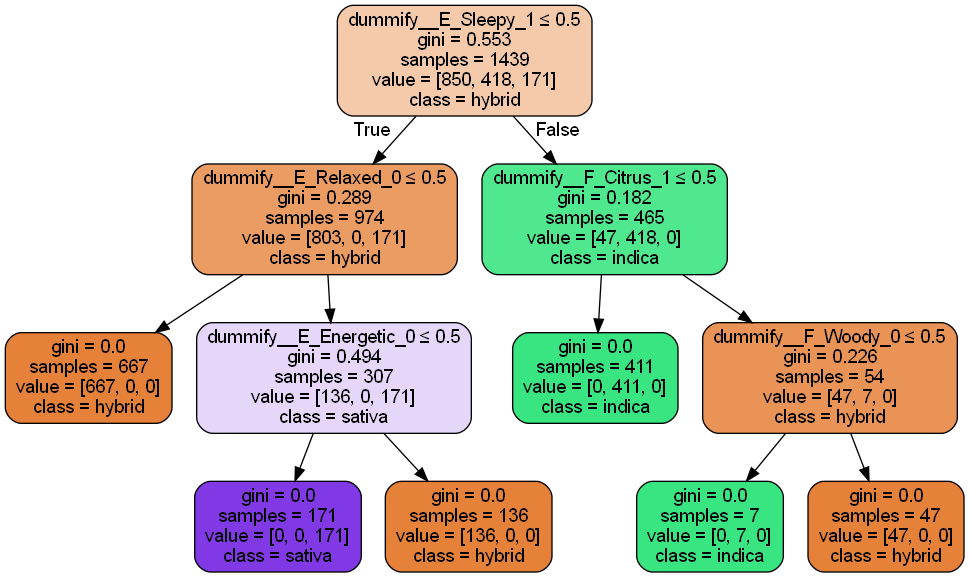

In [24]:
from sklearn.tree import export_graphviz
from IPython.display import display, Image
import graphviz

# Perform cross-validated predictions
y_pred_cv = model_4_pred

# Get the indices of correctly classified instances
correct_indices = (y == y_pred_cv)

# Use the correct indices to fit the model on the entire dataset
model_4_pipeline.fit(X[correct_indices], y[correct_indices])

# Get the transformed feature names from the preprocessor
transformed_feature_names = list(ct_no_standardize.get_feature_names_out(X.columns))

# Convert class names to strings
class_names_str = model_4_pipeline.named_steps['des_classification'].classes_.astype(str)

# Export the decision tree to a DOT file
dot_data = export_graphviz(model_4_pipeline.named_steps['des_classification'],
                           feature_names=transformed_feature_names,
                           class_names=class_names_str,  # Convert class names to strings
                           filled=True,
                           rounded=True,
                           special_characters=True,
                           out_file=None)

# Render the decision tree directly
graph = graphviz.Source(dot_data, format="png")
display(Image(graph.render(format='png', cleanup=True)))

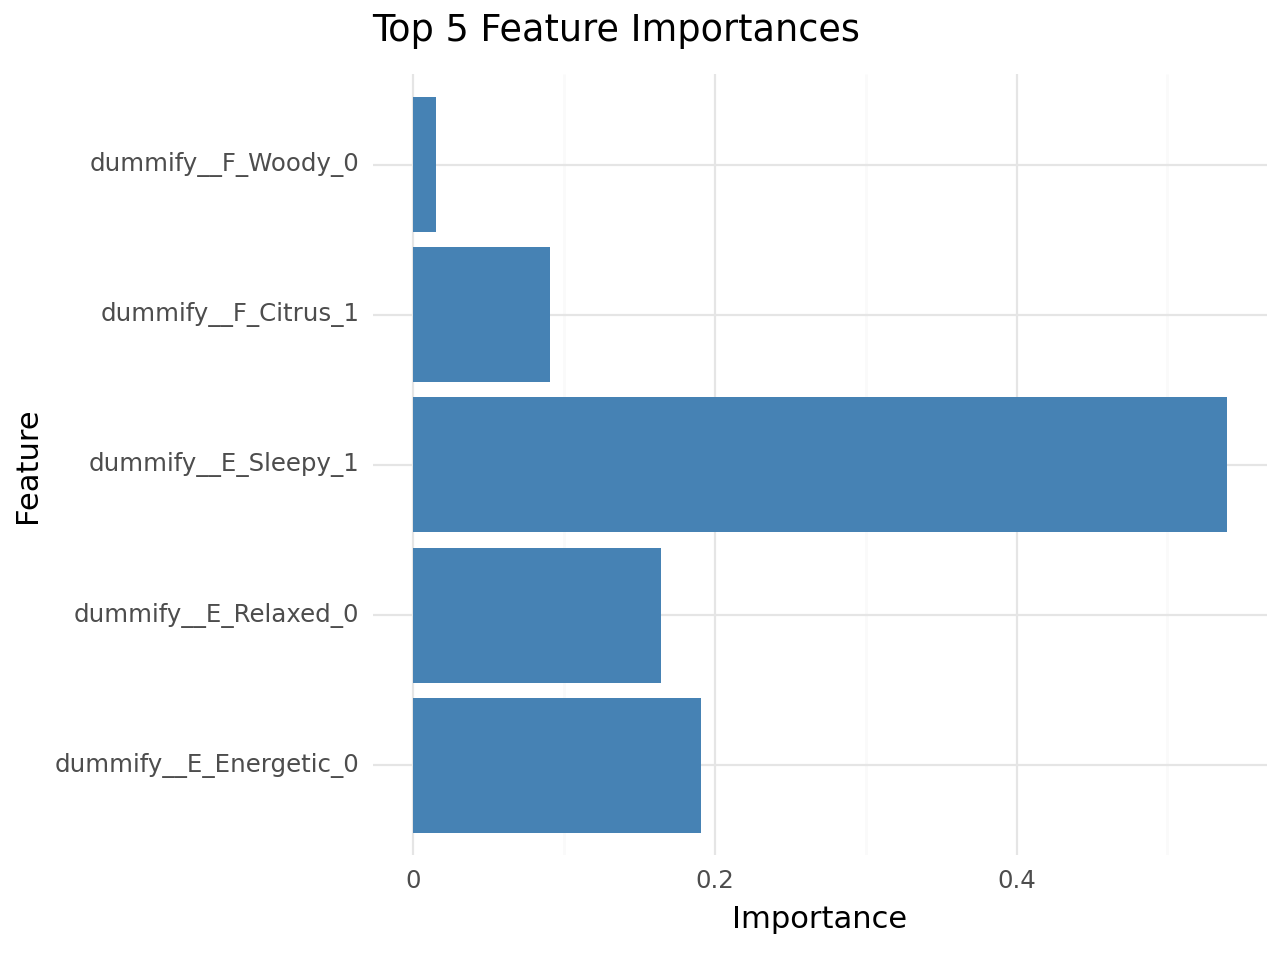

<Figure Size: (640 x 480)>

In [25]:
# Get feature importances
feature_importances = model_4_pipeline.named_steps["des_classification"].feature_importances_

# Get the corresponding feature names
feature_names = list(ct_no_standardize.get_feature_names_out(X.columns))

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the sorted feature importances
feature_importance_df.head()

feature_plot = (
    ggplot(feature_importance_df.head(), aes(x='Feature', y='Importance'))
    + geom_bar(stat='identity', fill='steelblue')
    + theme_minimal()
    + coord_flip()  # Horizontal bar plot
    + labs(title='Top 5 Feature Importances', x='Feature', y='Importance')
)
feature_plot
#feature_importance_df.head()

## Q2 LDA, QDA, and KNN
Repeat the analyses from Part One for LDA, QDA, and KNN.

### LDA

In [26]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# Model Specification
lda = LinearDiscriminantAnalysis()

#pipeline Creation
model_1_pipeline = Pipeline(
    [("preprocessing", ct),
    ("lda_classification", lda)]
  )

# Metrics for Model 3
print("Metrics for Model_1 :\n")

# Accuracy calculation
cv_scores = cross_val_score(model_1_pipeline, X, y, cv=cv, scoring='accuracy') # Perform cross-validation
roc_auc_model_1 = np.mean(cv_scores)
print("Mean Accuracy Score:", roc_auc_model_1, "\n")

# Confusion matrix
model_1 = model_1_pipeline.fit(X,y)
model_1_pred = model_1.predict(X)
uni_classes = y.unique() #getting the unique classes in the Y variale
conf_matrix_test = confusion_matrix(y, model_1_pred) # making the matrix
class_names = uni_classes.tolist() # Putting the classes to a list
conf_matrix_df = pd.DataFrame(conf_matrix_test, index=class_names, columns=class_names) # Display the confusion matrix with class labels
print("Confusion Matrix for Model_3 : \n")
conf_matrix_df

Metrics for Model_1 :

Mean Accuracy Score: 0.6302090578870082 

Confusion Matrix for Model_3 : 



,hybrid,sativa,indica
hybrid,825,205,139
sativa,207,462,11
indica,220,20,188


### QDA

In [27]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# Model Specification
qda = QuadraticDiscriminantAnalysis()

#pipeline Creation
model_2_pipeline = Pipeline(
    [("preprocessing", ct),
    ("qda_classification", qda)]
  )

model_2 = model_2_pipeline.fit(X,y)

model_2_pred = model_2.predict(X)

# Metrics for Model 2
print("Metrics for Model_2 :\n")

# Accuracy calculation
cv_scores = cross_val_score(model_2_pipeline, X, y, cv=cv, scoring='accuracy') # Perform cross-validation
roc_auc_model_2 = np.mean(cv_scores)
print("Mean Accuracy Score:", roc_auc_model_2, "\n")

# Confusion matrix
uni_classes = y.unique() #getting the unique classes in the Y variale
conf_matrix_test = confusion_matrix(y, model_2_pred) # making the matrix
class_names = uni_classes.tolist() # Putting the classes to a list
conf_matrix_df = pd.DataFrame(conf_matrix_test, index=class_names, columns=class_names) # Display the confusion matrix with class labels
print("Confusion Matrix for Model_2 : \n")
conf_matrix_df

Metrics for Model_2 :

Mean Accuracy Score: 0.35528247932606843 

Confusion Matrix for Model_2 : 



,hybrid,sativa,indica
hybrid,266,56,847
sativa,133,112,435
indica,37,4,387


### KNN

In [28]:
#Model Specification
knn = KNeighborsClassifier()

#pipeline Creation
model_3_pipeline = Pipeline(
    [("preprocessing", ct),
    ("knn_classification", knn)]
  )
#tuning using grid Search
params = {'knn_classification__n_neighbors': [1, 3, 5, 10, 50]}

gscv = GridSearchCV(model_3_pipeline, params, cv = cv, scoring='accuracy')

gscv_fitted = gscv.fit(X, y)

#getting the scores from the results
mean_test_scores = gscv_fitted.cv_results_['mean_test_score']

#getting the K's from the results corresponding to the
ks = gscv_fitted.cv_results_['param_knn_classification__n_neighbors']

# Creating a DataFrame with best parameterss and scores
model_scores = pd.DataFrame(data = {"K": ks, "accuracy": mean_test_scores}).sort_values(by='accuracy', ascending=False)
model_scores.head()

,K,accuracy
4,50,0.605601
3,10,0.591985
2,5,0.570921
1,3,0.563434
0,1,0.500636


In [29]:
#Model Specification
knn = KNeighborsClassifier(n_neighbors=model_scores.iloc[0,0])

#pipeline Creation
model_3_pipeline = Pipeline(
    [("preprocessing", ct),
    ("knn_classification", knn)]
  )

#fitting
model_3 = model_3_pipeline.fit(X,y)

#cross validated predictions
model_3_pred = model_3.predict(X)

# Metrics for Model 1
print("Metrics for Model_3 :\n")

# Accuracy calculation
cv_scores = cross_val_score(model_3_pipeline, X, y, cv=cv, scoring='accuracy') # Perform cross-validation
accuracy_model_3 = np.mean(cv_scores)
print("Mean accuracy Score:", accuracy_model_3, "\n")

# Confusion matrix
uni_classes = y.unique() #getting the unique classes in the Y variale
conf_matrix_test = confusion_matrix(y, model_3_pred) # making the matrix
class_names = uni_classes.tolist() # Putting the classes to a list
conf_matrix_df = pd.DataFrame(conf_matrix_test, index=class_names, columns=class_names) # Display the confusion matrix with class labels
print("Confusion Matrix for Model_3 : \n")
conf_matrix_df

Metrics for Model_3 :

Mean accuracy Score: 0.6056012829430404 

Confusion Matrix for Model_3 : 



,hybrid,sativa,indica
hybrid,942,187,40
sativa,269,406,5
indica,340,19,69


## Q3
Were your metrics better or worse than in Part One? Why? Which categories were most likely to get mixed up, according to the confusion matrices? Why?

The results were worse for every model given that now the models had to classify more than just two classes. Added to that the models had a harder time classifying between the hybrid variants which makes sense since these share characteristics with the other two types.

# Part Three: Multiclass from Binary
Consider two models designed for binary classification: SVC and Logistic Regression.

## Q1
Fit and report metrics for OvR versions of the models. That is, for each of the two model types, create three models:

### Indica vs. Not Indica

In [30]:
high['Type'].unique()

array(['hybrid', 'sativa', 'indica'], dtype=object)

In [31]:
# Create a new column 'type_indica' based on the categories
high['type_indica'] = high['Type'] == 'indica'

#creating the X and y to proceed
X = high.drop(['Type', 'Flavor', 'Effects', 'Strain', 'Description', 'type_indica'], axis = 1)
y = high["type_indica"]


#### SVC

In [32]:
from sklearn.svm import SVC

# Model Specification
svc = SVC(kernel='linear')  # You can specify different kernels based on your problem

# Pipeline Creation
model_1_pipeline = Pipeline([("preprocessing", ct),
    ("svc_classification", svc)
])

#tuning using grid Search
params = {'svc_classification__C': [.0001, .001, .01, .1, 1, 10]}

gscv = GridSearchCV(model_1_pipeline, params, cv = cv, scoring='f1')

gscv_fitted = gscv.fit(X, y)

#getting the scores from the results
mean_test_scores = gscv_fitted.cv_results_['mean_test_score']

#getting the K's from the results corresponding to the
lambdas = gscv_fitted.cv_results_['param_svc_classification__C']

# Creating a DataFrame with best parameterss and scores
model_scores = pd.DataFrame(data = {"lambda": lambdas, "f1": mean_test_scores}).sort_values(by='f1', ascending=False)
model_scores.head()

,lambda,f1
2,0.01,0.652749
3,0.1,0.652749
4,1,0.648708
5,10,0.646769
0,0.0001,0.000000


In [33]:
# Model Specification
svc = SVC(kernel='linear', C=model_scores.iloc[0, 0])  # You can specify different kernels based on your problem

# Pipeline Creation
model_1_pipeline = Pipeline([("preprocessing", ct),
    ("svc_classification", svc)
])

model_1 = model_1_pipeline.fit(X,y)

model_1_pred = model_1.predict(X)

# Metrics for Model 1
print("Metrics for Model_1 :\n")

# Accuracy calculation
cv_scores = cross_val_score(model_1_pipeline, X, y, cv=cv, scoring='f1') # Perform cross-validation
accuracy_model_1 = np.mean(cv_scores)
print("Mean F1 Score:", accuracy_model_1, "\n")

# Confusion matrix
uni_classes = y.unique() #getting the unique classes in the Y variale
conf_matrix_test = confusion_matrix(y, model_1_pred) # making the matrix
class_names = uni_classes.tolist() # Putting the classes to a list
conf_matrix_df = pd.DataFrame(conf_matrix_test, index=class_names, columns=class_names) # Display the confusion matrix with class labels
print("Confusion Matrix for Model_1 : \n")
conf_matrix_df

Metrics for Model_1 :

Mean F1 Score: 0.6527485773279549 

Confusion Matrix for Model_1 : 



,False,True
False,1334,263
True,223,457


#### Logistic Regression

In [34]:
#Model Specification
logreg = LogisticRegression(penalty='elasticnet',solver='saga')

#pipeline Creation
model_2_pipeline = Pipeline(
    [("preprocessing", ct),
    ("logisticreg_classification", logreg)]
  )
#tuning using grid Search
params = {'logisticreg_classification__C': [.0001, .001, .01, .1, 1, 10],
          'logisticreg_classification__l1_ratio':[.1, .2, .4, .6, .8, .9]}

gscv = GridSearchCV(model_2_pipeline, params, cv=cv, scoring='f1')

gscv_fitted = gscv.fit(X, y)

# Getting the scores from the results
mean_test_scores = gscv_fitted.cv_results_['mean_test_score']

# Getting the parameters corresponding to the models from the results
lambdas = gscv_fitted.cv_results_['param_logisticreg_classification__C']
alphas = gscv_fitted.cv_results_['param_logisticreg_classification__l1_ratio']

# Creating a DataFrame with best parameters and scores
model_scores = pd.DataFrame(data={"lambdas": lambdas, "alphas": alphas, "f1_score": mean_test_scores}).sort_values(by='f1_score', ascending=False)
model_scores[0:1]

,lambdas,alphas,f1_score
22,0.1,0.8,0.653544


In [35]:
model_scores.iloc[0,1]

0.8

In [36]:
#Model Specification
logreg = LogisticRegression(penalty='elasticnet',solver='saga', C=model_scores.iloc[0,0], l1_ratio=model_scores.iloc[0,1])

#pipeline Creation
model_2_pipeline = Pipeline(
    [("preprocessing", ct),
    ("logisticreg_classification", logreg)]
  )

# Metrics for Model 2
print("Metrics for Model_2 :\n")

# Accuracy calculation
cv_scores = cross_val_score(model_2_pipeline, X, y, cv=cv, scoring='f1') # Perform cross-validation
roc_auc_model_2 = np.mean(cv_scores)
print("Mean Accuracy Score:", roc_auc_model_2, "\n")

# Confusion matrix
model_2 = model_2_pipeline.fit(X,y)
model_2_pred = model_2.predict(X)
uni_classes = y.unique() #getting the unique classes in the Y variale
conf_matrix_test = confusion_matrix(y, model_2_pred) # making the matrix
class_names = uni_classes.tolist() # Putting the classes to a list
conf_matrix_df = pd.DataFrame(conf_matrix_test, index=class_names, columns=class_names) # Display the confusion matrix with class labels
print("Confusion Matrix for Model_2 : \n")
conf_matrix_df

Metrics for Model_2 :

Mean Accuracy Score: 0.6535441935706054 

Confusion Matrix for Model_2 : 



,False,True
False,1401,196
True,254,426


### Sativa vs. Not Sativa

In [37]:
# Create a new column 'type_indica' based on the categories
high['type_sativa'] = high['Type'] == 'sativa'

#creating the X and y to proceed
X = high.drop(['Type', 'Flavor', 'Effects', 'Strain', 'Description', 'type_indica', 'type_sativa'], axis = 1)
y = high["type_sativa"]
y

0       False
1       False
2        True
3       False
4       False
        ...  
2346    False
2347    False
2348    False
2349    False
2350    False
Name: type_sativa, Length: 2277, dtype: bool

#### SVC

In [38]:
# Model Specification
svc = SVC(kernel='linear')  # You can specify different kernels based on your problem

# Pipeline Creation
model_1_pipeline = Pipeline([("preprocessing", ct),
    ("svc_classification", svc)
])

#tuning using grid Search
params = {'svc_classification__C': [.0001, .001, .01, .1, 1, 10]}

gscv = GridSearchCV(model_1_pipeline, params, cv = cv, scoring='f1')

gscv_fitted = gscv.fit(X, y)

#getting the scores from the results
mean_test_scores = gscv_fitted.cv_results_['mean_test_score']

#getting the K's from the results corresponding to the
lambdas = gscv_fitted.cv_results_['param_svc_classification__C']

# Creating a DataFrame with best parameterss and scores
model_scores = pd.DataFrame(data = {"lambda": lambdas, "f1": mean_test_scores}).sort_values(by='f1', ascending=False)
model_scores.head()

,lambda,f1
5,10,0.284206
4,1,0.266358
0,0.0001,0.000000
1,0.001,0.000000
2,0.01,0.000000


In [39]:
# Model Specification
svc = SVC(kernel='linear', C=model_scores.iloc[0, 0])  # You can specify different kernels based on your problem

# Pipeline Creation
model_1_pipeline = Pipeline([("preprocessing", ct),
    ("svc_classification", svc)
])

model_1 = model_1_pipeline.fit(X,y)

model_1_pred = model_1.predict(X)

# Metrics for Model 1
print("Metrics for Model_1 :\n")

# Accuracy calculation
cv_scores = cross_val_score(model_1_pipeline, X, y, cv=cv, scoring='f1') # Perform cross-validation
accuracy_model_1 = np.mean(cv_scores)
print("Mean Accuracy Score:", accuracy_model_1, "\n")

# Confusion matrix
uni_classes = y.unique() #getting the unique classes in the Y variale
conf_matrix_test = confusion_matrix(y, model_1_pred) # making the matrix
class_names = uni_classes.tolist() # Putting the classes to a list
conf_matrix_df = pd.DataFrame(conf_matrix_test, index=class_names, columns=class_names) # Display the confusion matrix with class labels
print("Confusion Matrix for Model_1 : \n")
conf_matrix_df

Metrics for Model_1 :

Mean Accuracy Score: 0.28420566537145986 

Confusion Matrix for Model_1 : 



,False,True
False,1798,51
True,333,95


#### Logistic Regression

In [40]:
#Model Specification
logreg = LogisticRegression(penalty='elasticnet',solver='saga')

#pipeline Creation
model_2_pipeline = Pipeline(
    [("preprocessing", ct),
    ("logisticreg_classification", logreg)]
  )
#tuning using grid Search
params = {'logisticreg_classification__C': [.0001, .001, .01, .1, 1, 10],
          'logisticreg_classification__l1_ratio':[.1, .2, .4, .6, .8, .9]}

gscv = GridSearchCV(model_2_pipeline, params, cv=cv, scoring='f1')

gscv_fitted = gscv.fit(X, y)

# Getting the scores from the results
mean_test_scores = gscv_fitted.cv_results_['mean_test_score']

# Getting the parameters corresponding to the models from the results
lambdas = gscv_fitted.cv_results_['param_logisticreg_classification__C']
alphas = gscv_fitted.cv_results_['param_logisticreg_classification__l1_ratio']

# Creating a DataFrame with best parameters and scores
model_scores = pd.DataFrame(data={"lambdas": lambdas, "alphas": alphas, "f1_score": mean_test_scores}).sort_values(by='f1_score', ascending=False)
model_scores[0:1]

,lambdas,alphas,f1_score
34,10,0.8,0.400131


In [41]:
#Model Specification
logreg = LogisticRegression(penalty='elasticnet',solver='saga', C=model_scores.iloc[0,0], l1_ratio=model_scores.iloc[0,1])

#pipeline Creation
model_2_pipeline = Pipeline(
    [("preprocessing", ct),
    ("logisticreg_classification", logreg)]
  )

# Metrics for Model 2
print("Metrics for Model_2 :\n")

# Accuracy calculation
cv_scores = cross_val_score(model_2_pipeline, X, y, cv=cv, scoring='f1') # Perform cross-validation
mean_score = np.mean(cv_scores)
print("Mean F1 Score:", mean_score, "\n")

# Confusion matrix
model_2 = model_2_pipeline.fit(X,y)
model_2_pred = model_2.predict(X)
uni_classes = y.unique() #getting the unique classes in the Y variale
conf_matrix_test = confusion_matrix(y, model_2_pred) # making the matrix
class_names = uni_classes.tolist() # Putting the classes to a list
conf_matrix_df = pd.DataFrame(conf_matrix_test, index=class_names, columns=class_names) # Display the confusion matrix with class labels
print("Confusion Matrix for Model_2 : \n")
conf_matrix_df

Metrics for Model_2 :

Mean F1 Score: 0.39787213775062324 

Confusion Matrix for Model_2 : 



,False,True
False,1756,93
True,281,147


### Hybrid vs. Not Hybrid

In [42]:
# Create a new column 'type_indica' based on the categories
high['type_hybrid'] = high['Type'] == 'hybrid'

#creating the X and y to proceed
X = high.drop(['Type', 'Flavor', 'Effects', 'Strain', 'Description', 'type_indica', 'type_sativa', 'type_hybrid'], axis = 1)
y = high["type_hybrid"]
y.info()

<class 'pandas.core.series.Series'>
Int64Index: 2277 entries, 0 to 2350
Series name: type_hybrid
Non-Null Count  Dtype
--------------  -----
2277 non-null   bool 
dtypes: bool(1)
memory usage: 20.0 KB


#### SVC

In [43]:
from sklearn.svm import SVC

# Model Specification
svc = SVC(kernel='linear')  # You can specify different kernels based on your problem

# Pipeline Creation
model_1_pipeline = Pipeline([("preprocessing", ct),
    ("svc_classification", svc)
])

#tuning using grid Search
params = {'svc_classification__C': [.0001, .001, .01, .1, 1, 10]}

gscv = GridSearchCV(model_1_pipeline, params, cv = cv, scoring='f1')

gscv_fitted = gscv.fit(X, y)

#getting the scores from the results
mean_test_scores = gscv_fitted.cv_results_['mean_test_score']

#getting the K's from the results corresponding to the
lambdas = gscv_fitted.cv_results_['param_svc_classification__C']

# Creating a DataFrame with best parameterss and scores
model_scores = pd.DataFrame(data = {"lambda": lambdas, "f1": mean_test_scores}).sort_values(by='f1', ascending=False)
model_scores.head()

,lambda,f1
3,0.1,0.685548
2,0.01,0.685156
1,0.001,0.678501
0,0.0001,0.678468
4,1,0.676267


In [44]:
# Model Specification
svc = SVC(kernel='linear', C=model_scores.iloc[0, 0])  # You can specify different kernels based on your problem

# Pipeline Creation
model_1_pipeline = Pipeline([("preprocessing", ct),
    ("svc_classification", svc)
])

model_1 = model_1_pipeline.fit(X,y)

model_1_pred = model_1.predict(X)

# Metrics for Model 1
print("Metrics for Model_1 :\n")

# Accuracy calculation
cv_scores = cross_val_score(model_1_pipeline, X, y, cv=cv, scoring='f1') # Perform cross-validation
accuracy_model_1 = np.mean(cv_scores)
print("Mean Accuracy Score:", accuracy_model_1, "\n")

# Confusion matrix
uni_classes = y.unique() #getting the unique classes in the Y variale
conf_matrix_test = confusion_matrix(y, model_1_pred) # making the matrix
class_names = uni_classes.tolist() # Putting the classes to a list
conf_matrix_df = pd.DataFrame(conf_matrix_test, index=class_names, columns=class_names) # Display the confusion matrix with class labels
print("Confusion Matrix for Model_1 : \n")
conf_matrix_df

Metrics for Model_1 :

Mean Accuracy Score: 0.6855481903543517 

Confusion Matrix for Model_1 : 



,True,False
True,500,608
False,242,927


#### Logistic

In [45]:
#Model Specification
logreg = LogisticRegression(penalty='elasticnet',solver='saga')

#pipeline Creation
model_2_pipeline = Pipeline(
    [("preprocessing", ct),
    ("logisticreg_classification", logreg)]
  )
#tuning using grid Search
params = {'logisticreg_classification__C': [.0001, .001, .01, .1, 1, 10],
          'logisticreg_classification__l1_ratio':[.1, .2, .4, .6, .8, .9]}

gscv = GridSearchCV(model_2_pipeline, params, cv=cv, scoring='f1')

gscv_fitted = gscv.fit(X, y)

# Getting the scores from the results
mean_test_scores = gscv_fitted.cv_results_['mean_test_score']

# Getting the parameters corresponding to the models from the results
lambdas = gscv_fitted.cv_results_['param_logisticreg_classification__C']
alphas = gscv_fitted.cv_results_['param_logisticreg_classification__l1_ratio']

# Creating a DataFrame with best parameters and scores
model_scores = pd.DataFrame(data={"lambdas": lambdas, "alphas": alphas, "f1_score": mean_test_scores}).sort_values(by='f1_score', ascending=False)
model_scores[0:1]

,lambdas,alphas,f1_score
16,0.01,0.8,0.685156


In [46]:
#Model Specification
logreg = LogisticRegression(penalty='elasticnet',solver='saga', C=model_scores.iloc[0,0], l1_ratio=model_scores.iloc[0,1])

#pipeline Creation
model_2_pipeline = Pipeline(
    [("preprocessing", ct),
    ("logisticreg_classification", logreg)]
  )

# Metrics for Model 2
print("Metrics for Model_2 :\n")

# Accuracy calculation
cv_scores = cross_val_score(model_2_pipeline, X, y, cv=cv, scoring='f1') # Perform cross-validation
mean_score = np.mean(cv_scores)
print("Mean F1 Score:", mean_score, "\n")

# Confusion matrix
model_2 = model_2_pipeline.fit(X,y)
model_2_pred = model_2.predict(X)
uni_classes = y.unique() #getting the unique classes in the Y variale
conf_matrix_test = confusion_matrix(y, model_2_pred) # making the matrix
class_names = uni_classes.tolist() # Putting the classes to a list
conf_matrix_df = pd.DataFrame(conf_matrix_test, index=class_names, columns=class_names) # Display the confusion matrix with class labels
print("Confusion Matrix for Model_2 : \n")
conf_matrix_df

Metrics for Model_2 :

Mean F1 Score: 0.6851559637789054 

Confusion Matrix for Model_2 : 



,True,False
True,485,623
False,235,934


## Q2
Which of the six models did the best job distinguishing the target category from the rest? Which did the worst? Does this make intuitive sense?

- The best performing model in terms of F1 score was SVC for Hybrid vs. Not Hybrid. In this analysis with hybrid as the target class it was suprising to see the model perform better than the others. Hybrid classes share characteristics with indica and sativa therefore one would think that they would be harder to calssify. However, given that this is one versus rest analysis in which we have hybrid and rest this means that all features that were taken into account actually help hybrid to be classified. Since hybrid strains share characteristics (explanatory variables) there was more information to classify on.

## Q3
Fit and report metrics for OvO versions of the models. That is, for each of the two model types, create three models:

Indica vs. Sativa

Indica vs. Hybrid

Hybrid vs. Sativa

In [47]:
# Dropping the OVR columns
columns_to_drop = ['type_indica', 'type_sativa', 'type_hybrid']

# Drop the specified columns
high = high.drop(columns=columns_to_drop, axis = 1)

high.head()

,Strain,Type,Rating,Effects,Flavor,Description,E_Aroused,E_Creative,E_Dry,E_Energetic,E_Euphoric,E_Focused,E_Giggly,E_Happy,E_Hungry,E_Mouth,E_None,E_Relaxed,E_Sleepy,E_Talkative,E_Tingly,E_Uplifted,F_Ammonia,F_Apple,F_Apricot,F_Berry,F_Blue,F_Blueberry,F_Butter,F_Cheese,F_Chemical,F_Chestnut,F_Citrus,F_Coffee,F_Diesel,F_Earthy,F_Flowery,F_Fruit,F_Grape,F_Grapefruit,F_Honey,F_Lavender,F_Lemon,F_Lime,F_Mango,F_Menthol,F_Mint,F_Minty,F_None,F_Nutty,F_Orange,F_Peach,F_Pear,F_Pepper,F_Pine,F_Pineapple,F_Plum,F_Pungent,F_Rose,F_Sage,F_Skunk,F_Spicy/Herbal,F_Strawberry,F_Sweet,F_Tar,F_Tea,F_Tobacco,F_Tree,F_Tropical,F_Vanilla,F_Violet,F_Woody
0,100-Og,hybrid,4.0,"Creative,Energetic,Tingly,Euphoric,Relaxed","Earthy,Sweet,Citrus",$100 OG is a 50/50 hybrid strain that packs a ...,0,1,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,98-White-Widow,hybrid,4.7,"Relaxed,Aroused,Creative,Happy,Energetic","Flowery,Violet,Diesel",The ‘98 Aloha White Widow is an especially pot...,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1024 is a sativa-dominant hybrid bred in Spain...,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1
3,13-Dawgs,hybrid,4.2,"Tingly,Creative,Hungry,Relaxed,Uplifted","Apricot,Citrus,Grapefruit",13 Dawgs is a hybrid of G13 and Chemdawg genet...,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,24K-Gold,hybrid,4.6,"Happy,Relaxed,Euphoric,Uplifted,Talkative","Citrus,Earthy,Orange","Also known as Kosher Tangie, 24k Gold is a 60%...",0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Indica vs. Sativa

In [65]:
high_indica_sativa = high[(high['Type'] == "indica") | (high['Type'] == "sativa")]
high_indica_sativa['Type'] = high_indica_sativa['Type'].astype("category")

X = high_indica_sativa.drop(['Type', 'Flavor', 'Effects', 'Strain', 'Description'], axis = 1)
y = high_indica_sativa['Type'].astype("string")
# high_indica_sativa.info()

#### SVC

In [49]:
# Model Specification
svc = SVC(kernel='linear')  # You can specify different kernels based on your problem

# Pipeline Creation
model_1_pipeline = Pipeline([("preprocessing", ct),
    ("svc_classification", svc)
])

#tuning using grid Search
params = {'svc_classification__C': [.0001, .001, .01, .1, 1, 10]}

gscv = GridSearchCV(model_1_pipeline, params, cv = cv, scoring='roc_auc')

gscv_fitted = gscv.fit(X, y)

#getting the scores from the results
mean_test_scores = gscv_fitted.cv_results_['mean_test_score']

#getting the K's from the results corresponding to the
lambdas = gscv_fitted.cv_results_['param_svc_classification__C']

# Creating a DataFrame with best parameterss and scores
model_scores = pd.DataFrame(data = {"lambda": lambdas, "roc_auc": mean_test_scores}).sort_values(by='roc_auc', ascending=False)
model_scores.head()

,lambda,roc_auc
1,0.001,0.931149
0,0.0001,0.931013
2,0.01,0.930208
3,0.1,0.925351
5,10,0.920070


In [50]:
# Model Specification
svc = SVC(kernel='linear', C=model_scores.iloc[0, 0])  # You can specify different kernels based on your problem

# Pipeline Creation
model_1_pipeline = Pipeline([("preprocessing", ct),
    ("svc_classification", svc)
])

model_1 = model_1_pipeline.fit(X,y)

model_1_pred = model_1.predict(X)

# Metrics for Model 1
print("Metrics for Model_1 :\n")

# Accuracy calculation
cv_scores = cross_val_score(model_1_pipeline, X, y, cv=cv, scoring='roc_auc') # Perform cross-validation
accuracy_model_1 = np.mean(cv_scores)
print("Mean roc_auc_ovo Score:", accuracy_model_1, "\n")

# Confusion matrix
uni_classes = y.unique() #getting the unique classes in the Y variale
conf_matrix_test = confusion_matrix(y, model_1_pred) # making the matrix
class_names = uni_classes.tolist() # Putting the classes to a list
conf_matrix_df = pd.DataFrame(conf_matrix_test, index=class_names, columns=class_names) # Display the confusion matrix with class labels
print("Confusion Matrix for Model_1 : \n")
conf_matrix_df

Metrics for Model_1 :

Mean roc_auc_ovo Score: 0.9311494365187937 

Confusion Matrix for Model_1 : 



,sativa,indica
sativa,664,16
indica,195,233


#### Logistic Regression

In [51]:
#Model Specification
logreg = LogisticRegression(penalty='elasticnet',solver='saga')

#pipeline Creation
model_2_pipeline = Pipeline(
    [("preprocessing", ct),
    ("logisticreg_classification", logreg)]
  )
#tuning using grid Search
params = {'logisticreg_classification__C': [.0001, .001, .01, .1, 1, 10],
          'logisticreg_classification__l1_ratio':[.1, .2, .4, .6, .8, .9]}

gscv = GridSearchCV(model_2_pipeline, params, cv=cv, scoring='roc_auc')

gscv_fitted = gscv.fit(X, y)

# Getting the scores from the results
mean_test_scores = gscv_fitted.cv_results_['mean_test_score']

# Getting the parameters corresponding to the models from the results
lambdas = gscv_fitted.cv_results_['param_logisticreg_classification__C']
alphas = gscv_fitted.cv_results_['param_logisticreg_classification__l1_ratio']

# Creating a DataFrame with best parameters and scores
model_scores = pd.DataFrame(data={"lambdas": lambdas, "alphas": alphas, "roc_auc": mean_test_scores}).sort_values(by='roc_auc', ascending=False)
model_scores[0:1]

,lambdas,alphas,roc_auc
19,0.1,0.2,0.933688


In [52]:
#Model Specification
logreg = LogisticRegression(penalty='elasticnet',solver='saga', C=model_scores.iloc[0,0], l1_ratio=model_scores.iloc[0,1])

#pipeline Creation
model_2_pipeline = Pipeline(
    [("preprocessing", ct),
    ("logisticreg_classification", logreg)]
  )

# Metrics for Model 2
print("Metrics for Model_2 :\n")

# Accuracy calculation
cv_scores = cross_val_score(model_2_pipeline, X, y, cv=cv, scoring='roc_auc') # Perform cross-validation
mean_score = np.mean(cv_scores)
print("Mean roc_auc Score:", mean_score, "\n")

# Confusion matrix
model_2 = model_2_pipeline.fit(X,y)
model_2_pred = model_2.predict(X)
uni_classes = y.unique() #getting the unique classes in the Y variale
conf_matrix_test = confusion_matrix(y, model_2_pred) # making the matrix
class_names = uni_classes.tolist() # Putting the classes to a list
conf_matrix_df = pd.DataFrame(conf_matrix_test, index=class_names, columns=class_names) # Display the confusion matrix with class labels
print("Confusion Matrix for Model_2 : \n")
conf_matrix_df

Metrics for Model_2 :

Mean roc_auc Score: 0.9337058660673572 

Confusion Matrix for Model_2 : 



,sativa,indica
sativa,616,64
indica,87,341


### Indica vs. Hybrid

In [53]:
high_indica_hybrid = high[(high['Type'] == "indica") | (high['Type'] == "hybrid")]

X = high_indica_hybrid.drop(['Type', 'Flavor', 'Effects', 'Strain', 'Description'], axis = 1)
y = high_indica_hybrid["Type"]
y

0       hybrid
1       hybrid
3       hybrid
4       hybrid
5       indica
         ...  
2346    hybrid
2347    indica
2348    indica
2349    indica
2350    indica
Name: Type, Length: 1849, dtype: object

#### SVC

In [54]:
# Model Specification
svc = SVC(kernel='linear')  # You can specify different kernels based on your problem

# Pipeline Creation
model_1_pipeline = Pipeline([("preprocessing", ct),
    ("svc_classification", svc)
])

#tuning using grid Search
params = {'svc_classification__C': [.0001, .001, .01, .1, 1, 10]}

gscv = GridSearchCV(model_1_pipeline, params, cv = cv, scoring='roc_auc')

gscv_fitted = gscv.fit(X, y)

#getting the scores from the results
mean_test_scores = gscv_fitted.cv_results_['mean_test_score']

#getting the K's from the results corresponding to the
lambdas = gscv_fitted.cv_results_['param_svc_classification__C']

# Creating a DataFrame with best parameterss and scores
model_scores = pd.DataFrame(data = {"lambda": lambdas, "roc_auc": mean_test_scores}).sort_values(by='roc_auc', ascending=False)
model_scores.head()

,lambda,roc_auc
2,0.01,0.799962
1,0.001,0.799091
0,0.0001,0.799004
4,1,0.783017
3,0.1,0.779761


In [55]:
# Model Specification
svc = SVC(kernel='linear', C=model_scores.iloc[0, 0])  # You can specify different kernels based on your problem

# Pipeline Creation
model_1_pipeline = Pipeline([("preprocessing", ct),
    ("svc_classification", svc)
])

model_1 = model_1_pipeline.fit(X,y)

model_1_pred = model_1.predict(X)

# Metrics for Model 1
print("Metrics for Model_1 :\n")

# Accuracy calculation
cv_scores = cross_val_score(model_1_pipeline, X, y, cv=cv, scoring='roc_auc') # Perform cross-validation
accuracy_model_1 = np.mean(cv_scores)
print("Mean roc_auc Score:", accuracy_model_1, "\n")

# Confusion matrix
uni_classes = y.unique() #getting the unique classes in the Y variale
conf_matrix_test = confusion_matrix(y, model_1_pred) # making the matrix
class_names = uni_classes.tolist() # Putting the classes to a list
conf_matrix_df = pd.DataFrame(conf_matrix_test, index=class_names, columns=class_names) # Display the confusion matrix with class labels
print("Confusion Matrix for Model_1 : \n")
conf_matrix_df

Metrics for Model_1 :

Mean roc_auc Score: 0.7999620759002097 

Confusion Matrix for Model_1 : 



,hybrid,indica
hybrid,934,235
indica,223,457


#### Logistic Regression

In [56]:
#Model Specification
logreg = LogisticRegression(penalty='elasticnet',solver='saga')

#pipeline Creation
model_2_pipeline = Pipeline(
    [("preprocessing", ct),
    ("logisticreg_classification", logreg)]
  )
#tuning using grid Search
params = {'logisticreg_classification__C': [.0001, .001, .01, .1, 1, 10],
          'logisticreg_classification__l1_ratio':[.1, .2, .4, .6, .8, .9]}

gscv = GridSearchCV(model_2_pipeline, params, cv=cv, scoring='roc_auc')

gscv_fitted = gscv.fit(X, y)

# Getting the scores from the results
mean_test_scores = gscv_fitted.cv_results_['mean_test_score']

# Getting the parameters corresponding to the models from the results
lambdas = gscv_fitted.cv_results_['param_logisticreg_classification__C']
alphas = gscv_fitted.cv_results_['param_logisticreg_classification__l1_ratio']

# Creating a DataFrame with best parameters and scores
model_scores = pd.DataFrame(data={"lambdas": lambdas, "alphas": alphas, "roc_auc": mean_test_scores}).sort_values(by='roc_auc', ascending=False)
model_scores[0:1]

,lambdas,alphas,roc_auc
21,0.1,0.6,0.808988


In [57]:
#Model Specification
logreg = LogisticRegression(penalty='elasticnet',solver='saga', C=model_scores.iloc[0,0], l1_ratio=model_scores.iloc[0,1])

#pipeline Creation
model_2_pipeline = Pipeline(
    [("preprocessing", ct),
    ("logisticreg_classification", logreg)]
  )

# Metrics for Model 2
print("Metrics for Model_2 :\n")

# Accuracy calculation
cv_scores = cross_val_score(model_2_pipeline, X, y, cv=cv, scoring='roc_auc') # Perform cross-validation
mean_score = np.mean(cv_scores)
print("Mean roc_auc Score:", mean_score, "\n")

# Confusion matrix
model_2 = model_2_pipeline.fit(X,y)
model_2_pred = model_2.predict(X)
uni_classes = y.unique() #getting the unique classes in the Y variale
conf_matrix_test = confusion_matrix(y, model_2_pred) # making the matrix
class_names = uni_classes.tolist() # Putting the classes to a list
conf_matrix_df = pd.DataFrame(conf_matrix_test, index=class_names, columns=class_names) # Display the confusion matrix with class labels
print("Confusion Matrix for Model_2 : \n")
conf_matrix_df

Metrics for Model_2 :

Mean roc_auc Score: 0.8089693204868155 

Confusion Matrix for Model_2 : 



,hybrid,indica
hybrid,968,201
indica,241,439


### Hybrid vs. Sativa

In [58]:
high_hybrid_sativa = high[(high['Type'] == "hybrid") | (high['Type'] == "sativa")]

X = high_hybrid_sativa.drop(['Type', 'Flavor', 'Effects', 'Strain', 'Description'], axis = 1)
y = high_hybrid_sativa["Type"]
y

0       hybrid
1       hybrid
2       sativa
3       hybrid
4       hybrid
         ...  
2342    sativa
2343    sativa
2344    hybrid
2345    sativa
2346    hybrid
Name: Type, Length: 1597, dtype: object

#### SVC

In [59]:
# Model Specification
svc = SVC(kernel='linear')  # You can specify different kernels based on your problem

# Pipeline Creation
model_1_pipeline = Pipeline([("preprocessing", ct),
    ("svc_classification", svc)
])

#tuning using grid Search
params = {'svc_classification__C': [.0001, .001, .01, .1, 1, 10]}

gscv = GridSearchCV(model_1_pipeline, params, cv = cv, scoring='roc_auc')

gscv_fitted = gscv.fit(X, y)

#getting the scores from the results
mean_test_scores = gscv_fitted.cv_results_['mean_test_score']

#getting the K's from the results corresponding to the
lambdas = gscv_fitted.cv_results_['param_svc_classification__C']

# Creating a DataFrame with best parameterss and scores
model_scores = pd.DataFrame(data = {"lambda": lambdas, "roc_auc": mean_test_scores}).sort_values(by='roc_auc', ascending=False)
model_scores.head()

,lambda,roc_auc
2,0.01,0.743196
1,0.001,0.742931
0,0.0001,0.741933
3,0.1,0.741257
4,1,0.732499


In [60]:
# Model Specification
svc = SVC(kernel='linear', C=model_scores.iloc[0, 0])  # You can specify different kernels based on your problem

# Pipeline Creation
model_1_pipeline = Pipeline([("preprocessing", ct),
    ("svc_classification", svc)
])

model_1 = model_1_pipeline.fit(X,y)

model_1_pred = model_1.predict(X)

# Metrics for Model 1
print("Metrics for Model_1 :\n")

# Accuracy calculation
cv_scores = cross_val_score(model_1_pipeline, X, y, cv=cv, scoring='roc_auc') # Perform cross-validation
accuracy_model_1 = np.mean(cv_scores)
print("Mean roc_auc Score:", accuracy_model_1, "\n")

# Confusion matrix
uni_classes = y.unique() #getting the unique classes in the Y variale
conf_matrix_test = confusion_matrix(y, model_1_pred) # making the matrix
class_names = uni_classes.tolist() # Putting the classes to a list
conf_matrix_df = pd.DataFrame(conf_matrix_test, index=class_names, columns=class_names) # Display the confusion matrix with class labels
print("Confusion Matrix for Model_1 : \n")
conf_matrix_df

Metrics for Model_1 :

Mean roc_auc Score: 0.7431961493910171 

Confusion Matrix for Model_1 : 



,hybrid,sativa
hybrid,1169,0
sativa,428,0


#### Logistic Regression

In [61]:
#Model Specification
logreg = LogisticRegression(penalty='elasticnet',solver='saga')

#pipeline Creation
model_2_pipeline = Pipeline(
    [("preprocessing", ct),
    ("logisticreg_classification", logreg)]
  )
#tuning using grid Search
params = {'logisticreg_classification__C': [.0001, .001, .01, .1, 1, 10],
          'logisticreg_classification__l1_ratio':[.1, .2, .4, .6, .8, .9]}

gscv = GridSearchCV(model_2_pipeline, params, cv=cv, scoring='roc_auc')

gscv_fitted = gscv.fit(X, y)

# Getting the scores from the results
mean_test_scores = gscv_fitted.cv_results_['mean_test_score']

# Getting the parameters corresponding to the models from the results
lambdas = gscv_fitted.cv_results_['param_logisticreg_classification__C']
alphas = gscv_fitted.cv_results_['param_logisticreg_classification__l1_ratio']

# Creating a DataFrame with best parameters and scores
model_scores = pd.DataFrame(data={"lambdas": lambdas, "alphas": alphas, "roc_auc": mean_test_scores}).sort_values(by='roc_auc', ascending=False)
model_scores[0:1]

,lambdas,alphas,roc_auc
22,0.1,0.8,0.748554


In [62]:
#Model Specification
logreg = LogisticRegression(penalty='elasticnet',solver='saga', C=model_scores.iloc[0,0], l1_ratio=model_scores.iloc[0,1])

#pipeline Creation
model_2_pipeline = Pipeline(
    [("preprocessing", ct),
    ("logisticreg_classification", logreg)]
  )

# Metrics for Model 2
print("Metrics for Model_2 :\n")

# Accuracy calculation
cv_scores = cross_val_score(model_2_pipeline, X, y, cv=cv, scoring='roc_auc') # Perform cross-validation
mean_score = np.mean(cv_scores)
print("Mean roc_auc Score:", mean_score, "\n")

# Confusion matrix
model_2 = model_2_pipeline.fit(X,y)
model_2_pred = model_2.predict(X)
uni_classes = y.unique() #getting the unique classes in the Y variale
conf_matrix_test = confusion_matrix(y, model_2_pred) # making the matrix
class_names = uni_classes.tolist() # Putting the classes to a list
conf_matrix_df = pd.DataFrame(conf_matrix_test, index=class_names, columns=class_names) # Display the confusion matrix with class labels
print("Confusion Matrix for Model_2 : \n")
conf_matrix_df

Metrics for Model_2 :

Mean roc_auc Score: 0.7485536145520106 

Confusion Matrix for Model_2 : 



,hybrid,sativa
hybrid,1080,89
sativa,303,125


## Q4
Which of the six models did the best job distinguishing at differentiating the two groups? Which did the worst? Does this make intuitive sense?

Best Model:
- the logistic regression model for Indica Vs Sativa did the best at distinguishing between the binary classes as measured by ROC AUC score. the model has an ROC AUC score of 93%. The model was tuned to have a lambda of .1 and an alpha of .2. Logistic regression is especially built for these binary classification problems and the penalty imposed with elastic net allowed us to get to that high of a cross validated metric. It would be interesting to see how this model would perform on new data.

Worst Model:
- Hybrid Vs Sativa with the SVC model performed the least favorable with an ROC AUC score of 74%. This makes sense intuitively with the fact that a hybrid strain shares classifications with the other strains. The second worst performing model was also another with hybrid in it vs another strain. Intuitively we can say that because hybrids share characteristics with indica and sativa, then classifying a hybrid strain vs sativa could pose difficulty if they are too similar.

## Q5
Suppose you had simply input the full data, with three classes, into the LogisticRegression function. Would this have automatically taken an “OvO” approach or an “OvR” approach?

What about for SVC?

Note: You do not actually have to run code here - you only need to look at sklearn’s documentation to see how these functions handle multiclass input.

LogisticRegression
- When there are more than two classes LogisticRegression sets a parameter multi_class = auto, which automatically chooses to run multinomoal logistic regression. What this does is, instead of looking for the probability of a binary class between 0 and 1 assigning the greater probabilities to class 1 past a threshold, it calculates the probabilities for each possible class. The model outputs a set of probabilities for each class and when predicting it will choose the class with the highest probability to classify.

SVC
- Accoring to the SVC documentation "The multiclass support is handled according to a one-vs-one scheme." Which would mean that SVC when handling a mulitclass problem will perform one vs one training sessions for each combination of classes. When it comes to predictions it will pick the class that beat all the other classes in the individual classification steps. The approach is straighforward and easy to understand, however can become computationally costly as it would have to run several training models under the hood if given a multitude of classes.